In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import matplotlib as mpl
import contextily as ctx

import os

from src import config, utils, plotting, preprocessing

# 1 Exploring available features

For this project, I'm pulling from two sources: the 2020 Decennial Census Demographic Profile (DP) and the 2023 5-year American Community Survey (ACS). Let's find useful features!

Ultimately, I anticipate using between 10-15 features to train the model&mdash;more will likely introduce high-dimensional noise&mdash;so I don't think I'll need any crosstabs data (e.g., I'm not going to pull a single Census variable for the number of people of a certain age and race, instead treating those as separate variables). That still leaves a lot more than 15 variables, so I'll need to be selective. In my opinion, an ideal feature has the following:
- spatial correlation
- large prominence (i.e., no varables describing <5% of the population)
- non-redundant information
- works in percentages rather than total counts

## 1.1 DP: Race and Hispanic origin

Let's start with racial/ethnic demographics and see if we can reduce the dimensionality to 4 or 5 compositional features.

In [41]:
# Load in DP and geometries
decennial2020_dp = pd.read_parquet(config.DECENNIAL2020_DP_CLEAN)
tracts = gpd.read_parquet(config.TRACTS_CLEAN)

We'll start by looking at all possible combinations of race and Hispanic origin from the Census data:

In [42]:
# Get race + hispanic percentages
race_vals = ["white","black","nativeam","asian","hipacific","other","multi"]
hisp_vals = ["hispanic","nonhisp"]
racehisp_vals = [f"{h}_{r}" for h in hisp_vals for r in race_vals]
for racehisp in racehisp_vals:
    decennial2020_dp[f"frac_{racehisp}"] = decennial2020_dp[f"pop_{racehisp}"] / decennial2020_dp["pop"]

racehisp_cols = [f"frac_{racehisp}" for racehisp in racehisp_vals]
dp_racehisp = decennial2020_dp[racehisp_cols].copy()

# See max representation for each category across tracts
dp_racehisp.max().sort_values(ascending=False)

frac_nonhisp_white         0.957917
frac_nonhisp_black         0.908904
frac_nonhisp_asian         0.905674
frac_hispanic_other        0.706831
frac_nonhisp_other         0.264163
frac_hispanic_multi        0.214399
frac_hispanic_white        0.206064
frac_nonhisp_multi         0.173235
frac_hispanic_black        0.091310
frac_hispanic_nativeam     0.073391
frac_hispanic_asian        0.055498
frac_nonhisp_nativeam      0.050021
frac_nonhisp_hipacific     0.016698
frac_hispanic_hipacific    0.013444
dtype: float64

It looks like `hispanic_other`, `nonhisp_white`, `nonhisp_black`, and `nonhisp_asian` each have tracts where they make up over 50% of the population (the rest do not). A quick look at the correlation matrix reveals that the Hispanic categories are highly correlated with each other. This motivates creating five features: `hispanic` (all races), `white` (non-Hispanic), `black` (non-Hispanic), `asian` (non-Hispanic), and `other` (everything else to complete the compositional dataset).

In [43]:
# Create five-feature race compositional data
dp_race5 = dp_racehisp.copy()
dp_race5["frac_hispanic"] = dp_race5[
    [f"frac_hispanic_{r}" for r in race_vals]
].sum(axis=1)
for r in ["white","black","asian"]:
    dp_race5[f"frac_{r}"] = dp_race5[f"frac_nonhisp_{r}"]
dp_race5["frac_other"] = dp_race5[[
    "frac_nonhisp_nativeam","frac_nonhisp_hipacific","frac_nonhisp_other","frac_nonhisp_multi"
]].sum(axis=1)

# Remove old columns
dp_race5 = dp_race5.drop(columns=dp_racehisp.columns.values)

dp_race5.describe()

,frac_hispanic,frac_white,frac_black,frac_asian,frac_other
count,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000
mean,0.268668,0.303852,0.216531,0.157439,0.053510
std,0.210878,0.274584,0.257606,0.174601,0.042309
min,0.005706,0.002157,0.000000,0.000000,0.006259
25%,0.108403,0.040691,0.020083,0.033570,0.028956
50%,0.185548,0.228454,0.083696,0.087946,0.046480
75%,0.377387,0.542693,0.346928,0.221781,0.064199
max,0.912103,0.957917,0.908904,0.905674,0.430649


We can perform principal component analysis (PCA) to see if there are any low-variance directions we can further eliminate. Since this is compositional data, we'll first apply a centered log-ratio (CLR) transformation to recover a Euclidean metric.

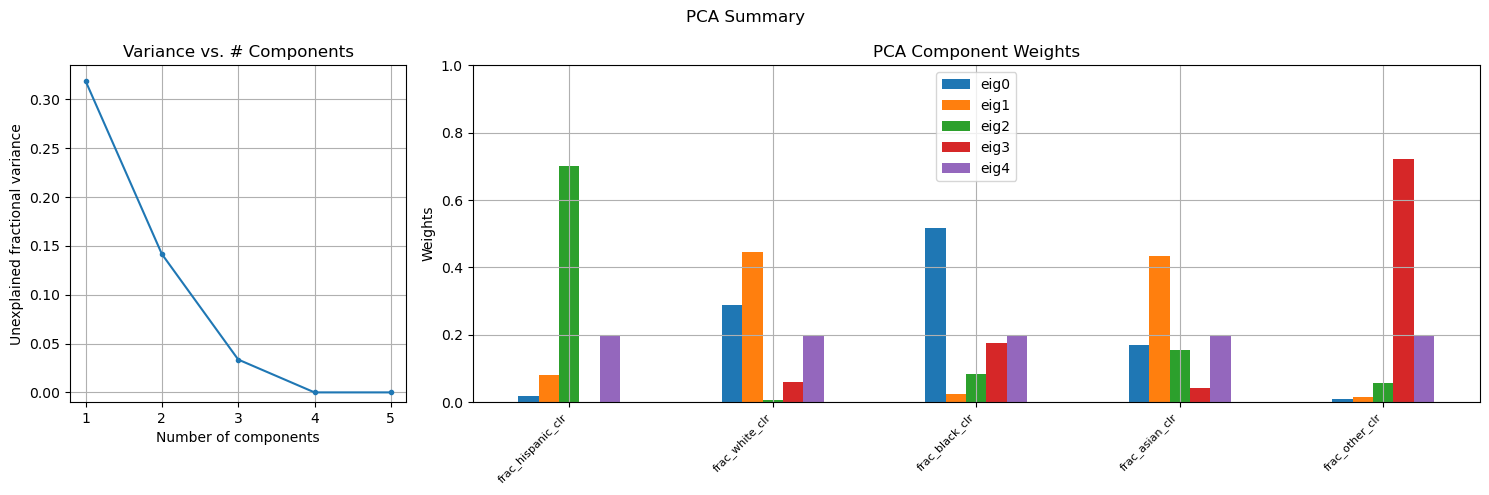

In [44]:
# Perform PCA on the CLR-transformed compositional data
dp_race5_clr = pd.DataFrame(
    utils.CLR(dp_race5.to_numpy()),
    index=dp_race5.index.values,
    columns=[col + "_clr" for col in dp_race5.columns.values]
)
pca, fig, ax = plotting.plot_pca_summary(dp_race5_clr)

With CLR-transformed compositional data, the final component (here, `eig4`) can be discarded because it reflects the data's collinearity and therefore carries zero variance. More notably, `eig3` is also not particularly helpful, which can be seen in the left plot by the fact that the first three components (`eig0`, `eig1`, and `eig2`) explain ~96% of the total variance. Since over 70% of the weight in `eig3` points along the "other" category, this suggests we can get away with a four-category race sector combining "other" with (non-Hispanic) Asian categories:

In [40]:
# Combine Asian and other columns
dp_race4 = dp_race5.copy()
dp_race4["frac_raceother"] = dp_race5["frac_other"] + dp_race5["frac_asian"]
dp_race4 = dp_race4.drop(columns=["frac_asian","frac_other"])

# # CLR
# dp_race4_clr = utils.CLR(dp_race4)

dp_race4.corr()

,frac_hispanic,frac_white,frac_black,frac_raceother
frac_hispanic,1.000000,-0.497429,-0.110491,-0.257403
frac_white,-0.497429,1.000000,-0.600252,-0.084580
frac_black,-0.110491,-0.600252,1.000000,-0.390277
frac_raceother,-0.257403,-0.084580,-0.390277,1.000000


Since these features are collinear, we lose no information by dropping one of them from the final dataset. `frac_black` has the largest (linear) covariances, so let's drop that one.

In [45]:
features_race = dp_race4.drop(columns=["frac_black"]).copy()

## 1.2 DP: Households by type

The Demographic Profile divides households into those where the householder lives with their spouse ("married"), cohabits with a non-married partner ("cohabit"), or does not live with a partner ("single," further divided into male or female). This creates another compositional dataset that we can explore.

In [46]:
# Load in DP and geometries
decennial2020_dp = pd.read_parquet(config.DECENNIAL2020_DP_CLEAN)
tracts = gpd.read_parquet(config.TRACTS_CLEAN)

In [47]:
# Get household types
hh_types = ["married","cohabit","singlemale","singlefemale"]
for hh_type in hh_types:
    decennial2020_dp[f"frac_households_{hh_type}"] = decennial2020_dp[f"households_{hh_type}"] / decennial2020_dp["households"]

hh_cols = [f"frac_households_{hh_type}" for hh_type in hh_types]
dp_households = decennial2020_dp[hh_cols].copy()

# See max representation for each category across tracts
dp_households.max().sort_values(ascending=False)

frac_households_married         0.810714
frac_households_singlefemale    0.706485
frac_households_singlemale      0.652220
frac_households_cohabit         0.187648
dtype: float64

Cohabiting households are not that common. A look at the correlation matrix suggests it's the most correlated with single male households, so let's combine these into an `other` category.

In [48]:
dp_households3 = dp_households.copy()
dp_households3["frac_households_other"] = dp_households[["frac_households_singlemale","frac_households_cohabit"]].sum(axis=1)
dp_households3 = dp_households3.drop(columns=["frac_households_singlemale","frac_households_cohabit"])

# # CLR
# dp_households3_clr = utils.CLR(dp_households3)

Again, including all three features is redundant. Among these three, `frac_households_married` has the largest covariances with the other features, so we'll drop that column.

In [49]:
features_households = dp_households3.drop(columns=["frac_households_married"]).copy()

## 1.3 DP: Age and sex

To what extent do age and sex demographics create geographic regions? The Demographic Profile has very detailed age data, but I'll stick to a few variables to minimize the number of features: children, seniors, and male populations, along with median age.

In [50]:
# Load in DP and geometries
decennial2020_dp = pd.read_parquet(config.DECENNIAL2020_DP_CLEAN)
tracts = gpd.read_parquet(config.TRACTS_CLEAN)

In [51]:
agesex_cols = ["pop_male","pop_18plus","pop_65plus","medianage"]
dp_agesex = decennial2020_dp[agesex_cols].copy()

# Get fractional populations
for col in agesex_cols:
    if col == "medianage":
        continue
    dp_agesex["frac_" + col[4:]] = dp_agesex[col] / decennial2020_dp["pop"]

# Convert 18plus to under18
dp_agesex["frac_under18"] = 1 - dp_agesex["frac_18plus"]

# Clean up
dp_agesex = dp_agesex.drop(columns=["pop_male","pop_18plus","pop_65plus","frac_18plus"])
dp_agesex.describe()

,medianage,frac_male,frac_65plus,frac_under18
count,2212.000000,2212.000000,2212.000000,2212.000000
mean,37.881872,0.476805,0.149418,0.199213
std,5.775124,0.028980,0.060997,0.061769
min,15.200000,0.313956,0.011336,0.014396
25%,34.375000,0.458326,0.109208,0.164713
50%,37.400000,0.478443,0.142351,0.196692
75%,40.900000,0.494204,0.179084,0.230519
max,83.000000,0.654876,0.864267,0.582003


Some of these populations (especially `frac_male`) don't vary too much between the middle quartiles, but the min and max values still have large variances and could count for real geographic structure. To determine whether or not this is the case, I calculate a Moran's I statistic below. This quantifies a feature's spatial structure using a contiguity-weighted autocorrelation (a higher number means more spatial clustering, with a possible range of -1 to 1).

In [52]:
moran_I = utils.get_Morans_I(tracts.join(dp_agesex), attrs=dp_agesex.columns.values)

print(moran_I.sort_values(ascending=False))

frac_under18    0.745768
medianage       0.644027
frac_65plus     0.563327
frac_male       0.476559
Name: morans_I, dtype: float64


The fact that `frac_male` has a relatively low Moran's I suggests it's not particularly spatially structured, so I will drop this column. Next, the fraction of seniors in a Census tract is highly correlated with the median age, suggesting we don't need it as a standalone feature. See below:

In [53]:
dp_agesex.drop(columns=["frac_male"]).corr()

,medianage,frac_65plus,frac_under18
medianage,1.000000,0.861166,-0.455099
frac_65plus,0.861166,1.000000,-0.304689
frac_under18,-0.455099,-0.304689,1.000000


To reduce feature count further, I'm going to define a feature called `frac_workingage`, which represents the proportion of residents who are not under 18 or 65+. This minimizes first-order correlations with `medianage` and also exhibits interesting clusters of data points, as revealed in the below scatter plot. Our final age/sex sector therefore has two features: `medianage` and `frac_workingage`.

(<Figure size 450x450 with 1 Axes>,
 <Axes: title={'center': 'Feature comparison scatter plot'}, xlabel='medianage', ylabel='frac_workingage'>)

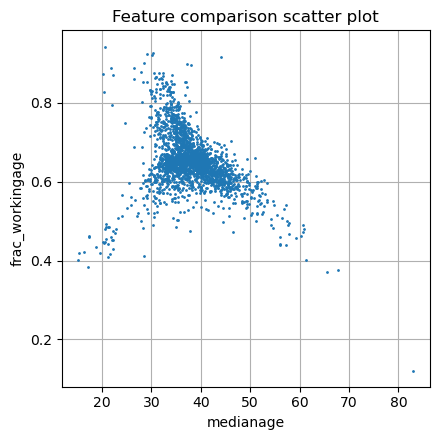

In [54]:
features_age = dp_agesex.copy()
features_age["frac_workingage"] = 1 - features_age[[
    "frac_under18","frac_65plus"
]].sum(axis=1)
features_age = features_age.drop(columns=[
    "frac_under18","frac_65plus","frac_male"
])

plotting.plot_feature_comparison(features_age, "medianage", "frac_workingage")

## 1.4 ACS: Economic data

The American Community Survey (ACS) contains many variables characterizing class/economic status of people, as well as the economic character of Census tracts. To keep things simple, I've identified three potentially interesting variables:
- median household income
- median rent
- fractional population below the poverty line

I suspect that these variables are all correlated, which I'd like to investigate. Is there a reason to include more than one?

In [55]:
# Load in ACS and geometries
acs5yr2023 = pd.read_parquet(config.ACS5YR2023_CLEAN)
tracts = gpd.read_parquet(config.TRACTS_CLEAN)

In [56]:
acs_econ = acs5yr2023[[
    "medianhouseholdincome","medianrent","pct_incomebelowpoverty"
]].copy()

# Convert percentage to fraction
acs_econ["frac_incomebelowpoverty"] = acs_econ["pct_incomebelowpoverty"] * 0.01
acs_econ = acs_econ.drop(columns=["pct_incomebelowpoverty"])
econ_cols = acs_econ.columns.to_list()

acs_econ.corr()

,medianhouseholdincome,medianrent,frac_incomebelowpoverty
medianhouseholdincome,1.000000,0.766181,-0.649355
medianrent,0.766181,1.000000,-0.510744
frac_incomebelowpoverty,-0.649355,-0.510744,1.000000


As expected, the covariances between these variables are all fairly high. Despite this, the predictive power of `medianhouseholdincome` (as quantified by an R2 measurement from linear regression) is only okay:

In [57]:
# Get R2 for linear regression on econ features vs. "medianhouseholdincome"
utils.get_feature_r2s(
    acs_econ[["medianhouseholdincome"]],
    acs_econ[["frac_incomebelowpoverty","medianrent"]],
    n_runs=100
)

,R2_mean,R2_std
frac_incomebelowpoverty,0.420283,0.031084
medianrent,0.577527,0.032467


We can improve this predictive power using nonlinear curve fits (particularly on `frac_incomebelowpoverty`). More importantly, I calculate Moran's I on the residuals for these nonlinear fits and find that most of the spatial structure is gone. This suggests that, although some variance remains after the curve fit, the variance is not strongly spatial and therefore won't provide useful clustering information. See below for summary plots.

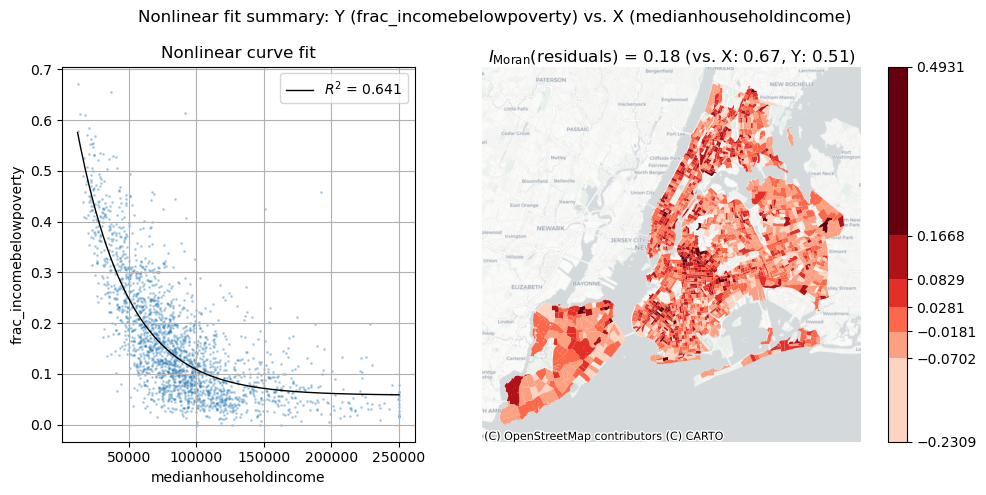

In [58]:
# Exponential fit
attr_x = "medianhouseholdincome"
attr_y = "frac_incomebelowpoverty"

def exponential_rescaled(x, a, b, c):
    return(a*np.exp(-b*(x * 1e-5)) + c)

fig, ax = plotting.plot_nonlinear_fit_summary(
    tracts.join(acs_econ), attr_x, attr_y, model=exponential_rescaled
)

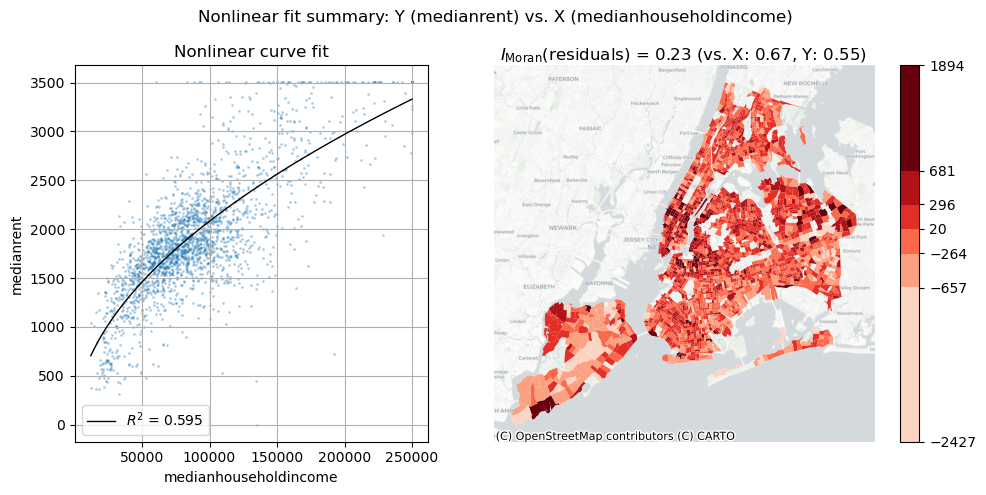

In [59]:
# Power law fit
attr_x = "medianhouseholdincome"
attr_y = "medianrent"

def power_rescaled(x, a, b):
    return(a * (x * 1e-5)**b)

fig, ax = plotting.plot_nonlinear_fit_summary(
    tracts.join(acs_econ), attr_x, attr_y, model=power_rescaled
)


That means I should be able to capture most of the spatial information using a single economic indicator: `medianhouseholdincome`.

In [60]:
features_econ = acs_econ[["medianhouseholdincome"]].copy()

## 1.5 DP + ACS: Urban/rural data

I can think of several variables dealing with how urban vs. rural a census tract is, including:
- Commute type (for example, the fraction of people commuting by walking, or by transit)
- Population density (`popdensity_sqmi`)
- Residential building type (for example, the fraction of buildings with 20+ units or 1 unit)
    - The ACS differentiates between attached and detached 1-unit housing. I will combine these into a single metric.
- Fraction of renters vs. homeowners

I'd like to whittle down this list a bit to keep the feature count small. First, let's combine these features into a dataset:

In [61]:
decennial2020_dp = pd.read_parquet(config.DECENNIAL2020_DP_CLEAN)
acs5yr2023 = pd.read_parquet(config.ACS5YR2023_CLEAN)
tracts = gpd.read_parquet(config.TRACTS_CLEAN)

In [62]:
## DP variables
# -- Population density --
pop = decennial2020_dp["pop"]
area_sqmi = tracts["AREA"] / (config.METERS_PER_MILE**2) # Convert m^2 to mi^2
popdensity_sqmi = pop / area_sqmi 
popdensity_sqmi.name = "popdensity_sqmi"

# -- Renter fraction --
housing = decennial2020_dp["housing"]
housing_renteroccupied = decennial2020_dp["housing_renteroccupied"]
frac_rentals = housing_renteroccupied / housing
frac_rentals.name = "frac_rentals"

In [63]:
## ACS variables
acs_urban_cols = [
  "pct_housing_1unitdetached",
  "pct_housing_1unitattached",
  "pct_housing_20plusunits",
  "pct_commute_transit",
  "pct_commute_walk"
]

acs_urban = acs5yr2023[acs_urban_cols].copy()

for col in acs_urban_cols:
    if col[:3] == "pct":
        acs_urban[col] = acs_urban[col] / 100
        acs_urban = acs_urban.rename(
            columns = {col: "frac" + col[3:]}
        )

# Put all variables together
combined_urban = pd.concat([popdensity_sqmi, frac_rentals, acs_urban], axis=1)

# Combine attached and detached 1-unit housing
combined_urban["frac_housing_1unit"] = combined_urban[["frac_housing_1unitattached","frac_housing_1unitdetached"]].sum(axis=1)
combined_urban = combined_urban.drop(columns=["frac_housing_1unitattached","frac_housing_1unitdetached"])

combined_urban.sample(n=5)

,popdensity_sqmi,frac_rentals,frac_housing_20plusunits,frac_commute_transit,frac_commute_walk,frac_housing_1unit
GEOID,,,,,,
36081126700,15136.961836,0.299866,0.000,0.383,0.083,0.697
36047092200,48640.911337,0.593294,0.547,0.600,0.006,0.009
36081001901,16261.133758,0.575439,0.942,0.695,0.038,0.000
36047041200,52873.845419,0.668071,0.235,0.237,0.086,0.249
36047152200,21836.733909,0.502435,0.516,0.300,0.038,0.371


If we regress each of these features on all the other ones, we find that `frac_housing_1unit` and `frac_rentals` are the most predictable as quantified by an $R^2$ score:

In [64]:
r2s = utils.get_internal_feature_r2s(combined_urban, n_runs=100)
r2s.sort_values(by="R2_mean", ascending=False)

,R2_mean,R2_std
frac_housing_1unit,0.735123,0.017622
frac_rentals,0.672141,0.026830
frac_commute_transit,0.551403,0.026719
frac_housing_20plusunits,0.507981,0.026049
popdensity_sqmi,0.444812,0.030099
frac_commute_walk,0.391838,0.034646


More careful nonlinear fits confirm that we can partially predict these features just off of population density, in a way that also reduces the spatial correlation of the residuals (though not completely):

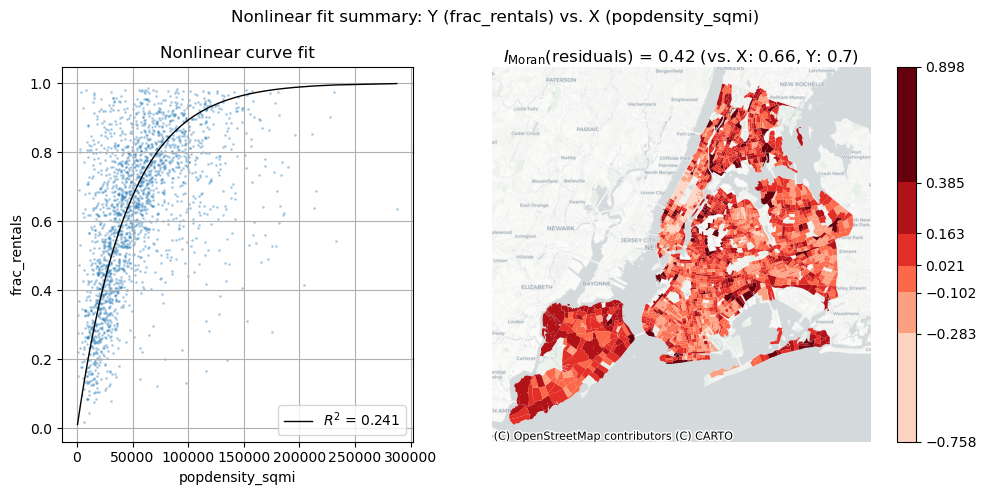

In [65]:
# Exponential fit
attr_x = "popdensity_sqmi"
attr_y = "frac_rentals"

def exponential_rescaled(x, a):
    return( 1 - np.exp(-a*(x*1e-5)) )

fig, ax = plotting.plot_nonlinear_fit_summary(
    tracts.join(combined_urban), attr_x, attr_y, model=exponential_rescaled
)

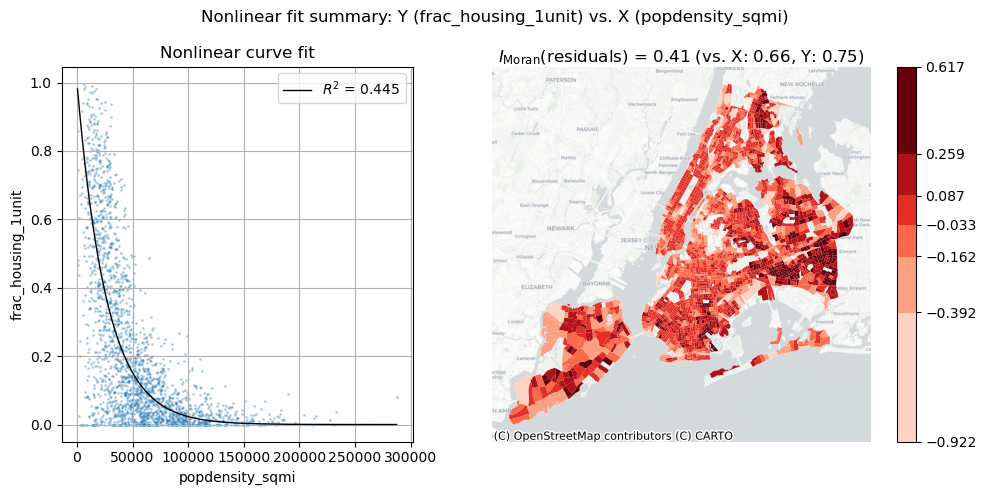

In [66]:
# Exponential fit
attr_x = "popdensity_sqmi"
attr_y = "frac_housing_1unit"

def exponential_rescaled(x, k):
    return( np.exp(-k * (x*1e-5)) )

fig, ax = plotting.plot_nonlinear_fit_summary(
    tracts.join(combined_urban), attr_x, attr_y, model=exponential_rescaled
)

Looking at the residual choropleth maps, the remaining spatial structure in `frac_rentals` has some interesting grouping in Manhattan, so I think I'll keep it for now and investigate if other features can independently identify these groups. The spatial structure in `frac_housing_1unit` seems to be more slowly varying across the city (and the $R^2$ value is substantially higher), so I will drop that feature.

In [67]:
features_urban = combined_urban.drop(columns=["frac_housing_1unit"]).copy()

## 1.6 Miscellaneous

Finally, we have a couply of miscellaneous variables that I think might carry interesting information:
- The fraction of residents who haven't moved in the past year (a proxy for transient populations?)
- The fraction of foreign-born residents (a proxy for identifying immigrant commnunities?)

In [68]:
# -- ACS variables --
misc_cols = ["pct_sameresidence1yr","pct_foreignborn"]
misc = acs5yr2023[misc_cols].copy()

for col in misc_cols:
    if col[:3] == "pct":
        misc[col] = misc[col] / 100
        misc = misc.rename(
            columns = {col: "frac" + col[3:]}
        )

# Confirm that the variables have some spatial structure
utils.get_Morans_I(tracts.join(misc), attrs=misc.columns)

frac_sameresidence1yr    0.474195
frac_foreignborn         0.721092
Name: morans_I, dtype: float64

In [69]:
features_misc = misc.copy()

# 2 Simplifying the feature set

The goal here is to combine all the features I collected in the previous section into a feature DataFrame, perform global checks and prune redundant information, and save as a processed dataset.

In [70]:
# Collect all features
features_all = pd.concat([
    features_race, features_households, features_age, features_econ, features_urban, features_misc
], axis=1)

features_all.shape # 15 features

(2212, 15)

I have multiple checks to look for redundant information:
- Calculate Moran's I on each feature to evaluate spatial structure
- Perform a regression on each feature, using the other columns as an input, to see how well we can predict this feature using the other data
- Calculate Moran's I on the residuals to see how much unexplained spatial structure remains in each feature after regression.

The results are summarized below.

In [71]:
# Calculate Moran's I on each feature
# Lower = less spatial structure
mIs = utils.get_Morans_I(tracts.join(features_all), attrs=features_all.columns)
mIs.sort_values(ascending=False)

frac_hispanic                   0.879471
frac_raceother                  0.870565
frac_white                      0.865696
frac_households_other           0.726636
frac_housing_20plusunits        0.721689
frac_foreignborn                0.721092
frac_rentals                    0.698640
frac_households_singlefemale    0.682269
frac_workingage                 0.680125
medianhouseholdincome           0.665374
frac_commute_walk               0.664064
popdensity_sqmi                 0.657165
medianage                       0.644027
frac_commute_transit            0.633542
frac_sameresidence1yr           0.474195
Name: morans_I, dtype: float64

In [72]:
# Perform regressions on each feature and calculate R2
# Higher = feature is globally more redundant
r2s = utils.get_internal_feature_r2s(features_all, n_runs=100)
r2s.sort_values(by="R2_mean", ascending=False)

,R2_mean,R2_std
frac_households_singlefemale,0.813827,0.014196
frac_rentals,0.799940,0.019406
frac_white,0.780892,0.013795
frac_households_other,0.766388,0.023691
frac_workingage,0.762978,0.022920
frac_raceother,0.682284,0.027536
frac_housing_20plusunits,0.637834,0.025568
medianage,0.632506,0.032778
medianhouseholdincome,0.617591,0.023150
frac_hispanic,0.603286,0.028760


In [73]:
# Calculate Moran's I on each regression's residuals
# Lower = feature's spatial structure is more redundant 
residual_mIs = utils.get_residual_spatial_structure(tracts.join(features_all), features_all.columns)
residual_mIs.sort_values(ascending=False)

frac_hispanic                   0.683189
frac_raceother                  0.588905
frac_white                      0.516769
frac_housing_20plusunits        0.495618
frac_foreignborn                0.400097
medianage                       0.394807
popdensity_sqmi                 0.383119
frac_commute_walk               0.367101
frac_households_singlefemale    0.329546
medianhouseholdincome           0.317472
frac_workingage                 0.301516
frac_rentals                    0.272244
frac_households_other           0.258620
frac_commute_transit            0.234010
frac_sameresidence1yr           0.106517
Name: residual_mI, dtype: float64

My takeaways from these three checks:
- Despite not being well-predicted with a regression, `frac_sameresidence1yr` does not carry much unique spatial structure, since its residuals' Moran's I is very low ($I = 0.11$). It also carries less overall spatial structure. Let's drop it.
- `frac_rentals` is pretty well predicted from other variables with a regression score of $R^2 = 0.79(2)$, and the residuals do not have much spatial structure ($I = 0.28$). Drop it.
- The fact that both household variables have high $R^2$ values suggests we might not need both of them. If we only choose one household value, `frac_households_married` might be the best choice actually, since it has the highest covariances with the other household compositional variables. Let's try subbing that in.
- `frac_commute_transit` also has a fairly low spatial structure after regression. Let's drop it too.

In [74]:
features_pruned = features_all.drop(columns=[
    "frac_households_other","frac_rentals","frac_sameresidence1yr","frac_households_singlefemale","frac_commute_transit"
]).copy() # 
features_pruned["frac_households_married"] = dp_households3["frac_households_married"]

features_pruned.shape # 11 features

(2212, 11)

In [75]:
r2s = utils.get_internal_feature_r2s(features_pruned, n_runs=100)
r2s.sort_values(by="R2_mean", ascending=False)

,R2_mean,R2_std
frac_households_married,0.817737,0.017980
frac_white,0.697616,0.022037
frac_workingage,0.662935,0.031132
frac_raceother,0.648881,0.026958
frac_housing_20plusunits,0.594459,0.025027
medianhouseholdincome,0.569680,0.024979
frac_foreignborn,0.564582,0.024785
frac_hispanic,0.483104,0.029407
medianage,0.454588,0.045521
popdensity_sqmi,0.424481,0.033554


In [76]:
residual_mIs = utils.get_residual_spatial_structure(tracts.join(features_pruned), features_pruned.columns)
residual_mIs.sort_values(ascending=False)

frac_hispanic               0.779253
frac_white                  0.651658
frac_raceother              0.637891
frac_housing_20plusunits    0.501462
medianage                   0.495561
frac_commute_walk           0.455668
frac_foreignborn            0.455178
popdensity_sqmi             0.440970
frac_households_married     0.401829
medianhouseholdincome       0.375774
frac_workingage             0.351332
Name: residual_mI, dtype: float64

This dataset seems pretty good to me. It has 11 features, and it covers a reasonable breadth of demographic and economic information without being too redundant. Let's save this dataset.

In [77]:
features_pruned.to_parquet(config.FEATURES_11)